In [2]:
import warnings

import geopandas as gpd
import numpy as np
import momepy
import rioxarray
import xvec

from streetscape import Streetscape

In [3]:
warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    message="invalid value encountered in intersection",
)

In [4]:
streets = gpd.read_file("/data/uscuni-streetscape/data_from_marek/select/gdf_streets_select.gpkg")
buildings = gpd.read_file("/data/uscuni-streetscape/data_from_marek/select/gdf_buildings_select.gpkg")
plots = gpd.read_file("/data/uscuni-streetscape/data_from_marek/select/gdf_parcels_select.gpkg")

<Axes: >

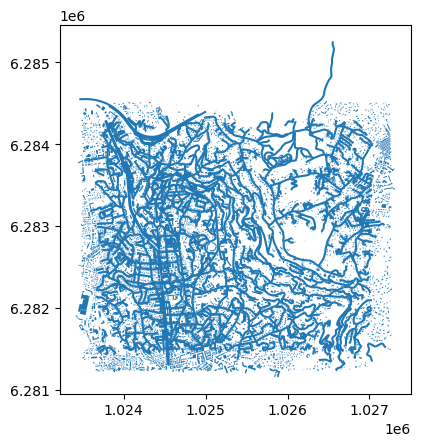

In [5]:
ax = streets.plot()
buildings.plot(ax=ax)

In [6]:
sc = Streetscape(streets, buildings)

In [8]:
%%time
sc.compute_sightline_indicators()

CPU times: user 2min 56s, sys: 46.4 ms, total: 2min 56s
Wall time: 2min 56s


In [9]:
df = sc.sightline_indicators
df.head(2)

,uid,sight_line_points,left_OS_count,left_OS,left_SB_count,left_SB,left_H,left_HW,left_BUILT_COVERAGE,left_SEQ_SB_ids,...,right_SEQ_SB_categories,front_SB,back_SB,left_SEQ_OS_endpoints,right_SEQ_OS_endpoints,nodes_degree_1,nodes_degree_4,nodes_degree_3_5_plus,street_length,windingness
uid,,,,,,,,,,,,,,,,,,,,,
0,0,"[POINT (1025242.6754464795 6281649.269788036),...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[50.0, 50.0, 50.0, 50.0, 50.0, 12.015897356951...","[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[nan, nan, nan, nan, nan, 12.015897356951728, ...","[nan, nan, nan, nan, nan, 10.0, 10.0, 10.0, 10...","[nan, nan, nan, nan, nan, 0.8322308108111924, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 6.599009503701802, 1...","[5606, 5606, 5606, 5606, 5606, 5606, 5606, 560...",...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[86.7802635552853, 89.86574230627636, 92.95122...","[59.59321622746305, 56.507737467190154, 53.422...","[POINT (1025275.696642899 6281686.8144359505),...","[POINT (1025209.65425006 6281611.725140122), P...",0.5,0.5,0.0,84.307926,0.088532
1,1,"[POINT (1025163.7509595673 6281587.984047531),...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[42.18169871784543, 50.0, 8.797188351925703, 8...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[42.18169871784543, nan, 8.797188351925703, 8....","[10.0, nan, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0...","[0.23706963692691188, nan, 1.1367268267947226,...","[7.8183012824172256, 0.0, 17.9741442580739, 41...","[1078, 1084, 1084, 1084, 1084, 1084, 1084, 108...",...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12.810757437896228, 15.833165138605596, 18.85...","[39.666311560408694, 36.643903859594325, 33.62...","[POINT (1025185.3462064692 6281633.080004238),...","[POINT (1025142.1557126653 6281542.888090825),...",0.0,0.5,0.5,112.829085,0.113218


In [35]:
df.loc[0]

uid                                                                        0
sight_line_points          [POINT (1025242.6754464795 6281649.269788036),...
left_OS_count              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
left_OS                    [50.0, 50.0, 50.0, 50.0, 50.0, 12.015897356951...
left_SB_count              [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
left_SB                    [nan, nan, nan, nan, nan, 12.015897356951728, ...
left_H                     [nan, nan, nan, nan, nan, 10.0, 10.0, 10.0, 10...
left_HW                    [nan, nan, nan, nan, nan, 0.8322308108111924, ...
left_BUILT_COVERAGE        [0.0, 0.0, 0.0, 0.0, 0.0, 6.599009503701802, 1...
left_SEQ_SB_ids            [5606, 5606, 5606, 5606, 5606, 5606, 5606, 560...
left_SEQ_SB_categories     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
right_OS_count             [1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, ...
right_OS                   [40.21409300681181, 50.0, 50.0, 50.0, 8.827360...

/home/martin/dev/streetscape/.pixi/envs/default/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/martin/dev/streetscape/.pixi/envs/default/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Axes: >

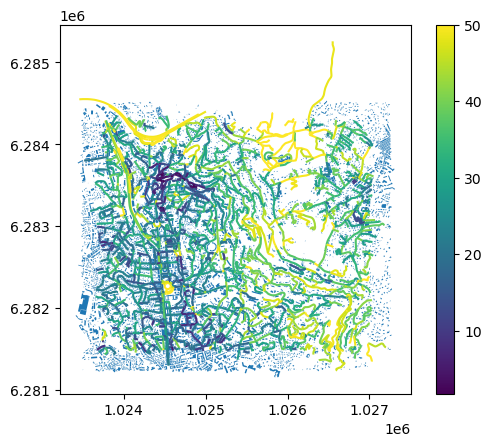

In [10]:
ax = sc.streets.plot(df.left_OS.apply(np.mean).values, legend=True)
buildings.plot(ax=ax)

<Axes: >

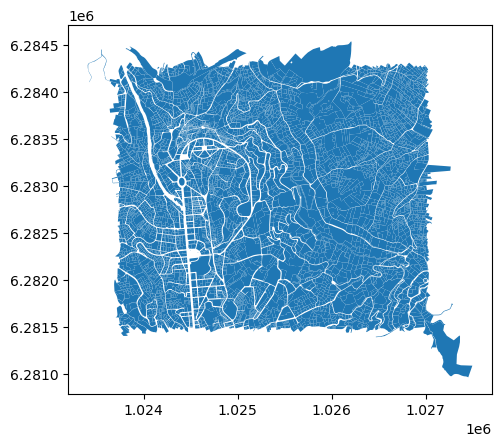

In [11]:
plots.plot()

In [13]:
%%time
sc.compute_plot_indicators(plots)

CPU times: user 1min 35s, sys: 24 ms, total: 1min 35s
Wall time: 1min 35s


In [14]:
df_plots = sc.plot_indicators
df_plots.head(2)

,uid,left_parcel_SB_count,left_parcel_SEQ_SB_ids,left_parcel_SEQ_SB,left_parcel_SEQ_SB_depth,right_parcel_SB_count,right_parcel_SEQ_SB_ids,right_parcel_SEQ_SB,right_parcel_SEQ_SB_depth
uid,,,,,,,,,
0,0,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[3476, 3476, 3479, 3479, 3479, 3479, 3479, 347...","[36.82972315729576, 7.648974870591288, 4.05030...","[40.1901116414097, 69.48728118341555, 4.050306...","[1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, ...","[4781, 3479, 3479, 3479, 3479, 3479, 3479, 347...","[40.44162126884802, 4.335545434370225, 3.82396...","[4.532114556130251, 1.347395763460938, 1.49086..."
1,1,"[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[4765, 4822, 4822, 4822, 4822, 4822, 4822, 482...","[42.20922859480632, 5.456679129884113, 4.76711...","[2.175696219500921, 9.037693478361113, 9.32820...","[1, 1, 1, 1, 3, 2, 2, 4, 2, 1, 2, 2, 3, 2, 1, ...","[4747, 4747, 4746, 4746, 4746, 4746, 4746, 474...","[6.160874609426495, 6.043105054034973, 6.18707...","[89.42219553381571, 92.9257671469239, 2.653929..."


/home/martin/dev/streetscape/.pixi/envs/default/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/martin/dev/streetscape/.pixi/envs/default/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Axes: >

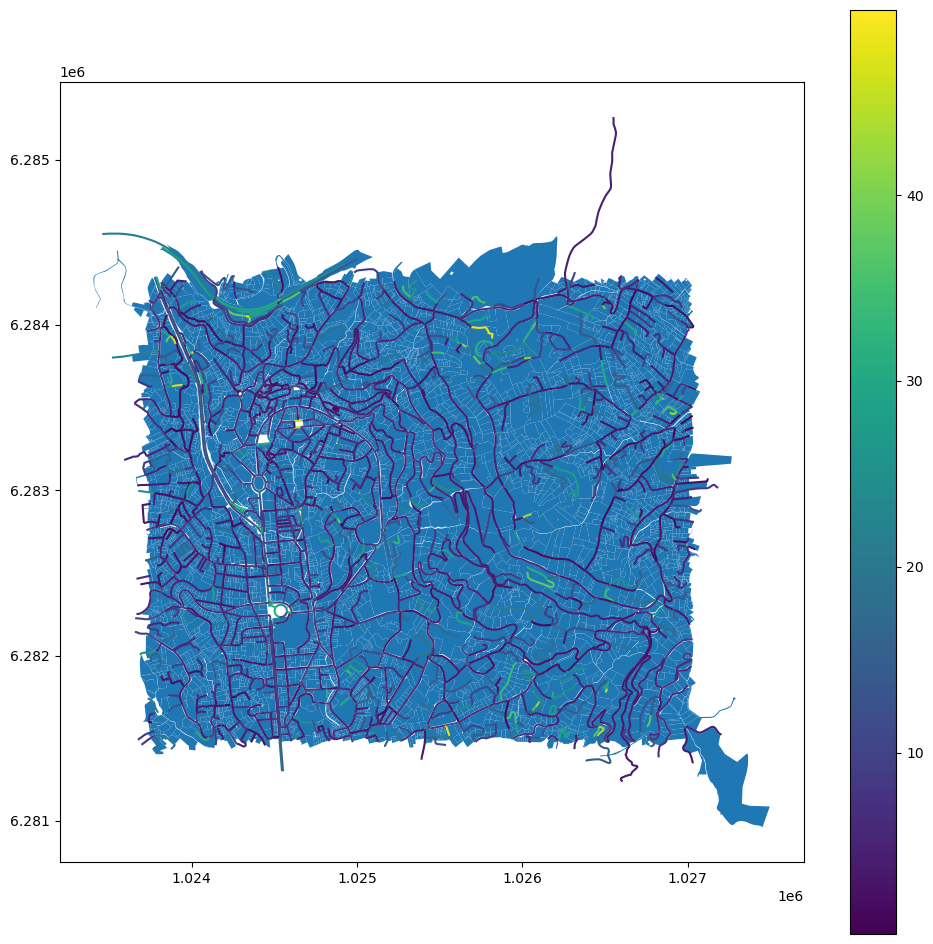

In [15]:
ax = sc.streets.plot(df_plots.right_parcel_SEQ_SB.apply(np.mean).values, legend=True, figsize=(12, 12))
plots.plot(ax=ax)

In [16]:
%%time
sc.compute_street_indicators()

CPU times: user 619 ms, sys: 2 ms, total: 621 ms
Wall time: 620 ms


In [17]:
street_df = sc.street_indicators
street_df.head(2)

,N,n_l,n_r,left_OS,right_OS,OS,left_OS_STD,right_OS_STD,OS_STD,left_OS_MAD,...,left_par_tot_15,right_par_tot_15,left_par_rel_15,right_par_rel_15,left_built_freq,right_built_freq,built_freq,left_built_coverage,right_built_coverage,built_coverage
uid,,,,,,,,,,,,,,,,,,,,,
0,28,23,18,24.311599,33.694404,58.006004,14.046756,18.123685,16.065797,11.199582,...,0.111111,0.222222,0.136364,0.352941,0.035584,0.106752,0.130474,0.280653,0.169784,0.225219
1,38,36,24,7.808276,30.404211,38.212488,12.143011,18.428582,15.501148,6.921991,...,0.756757,0.243243,0.800000,0.391304,0.088630,0.053178,0.141807,0.562825,0.135474,0.349149


In [20]:
sc.streets

,n1,n2,n1_degree,n2_degree,largeur_de,nature,uid,geometry,mm_len,node_start,node_end,dead_end_left,dead_end_right
0,1119440,12350050,4,1,3.0,Route à 1 chaussée,0,"LINESTRING (1025242.3 6281649.6, 1025250.6 628...",84.307926,0,1,False,True
1,6414032,1119440,4,3,4.0,Route à 1 chaussée,1,"LINESTRING (1025163.3 6281588.2, 1025170.4 628...",112.829085,0,1516,False,False
2,1119440,3064084,4,3,4.0,Route à 1 chaussée,2,"LINESTRING (1025242.3 6281649.6, 1025216 62816...",33.843463,0,8,False,False
3,1119440,4826707,4,3,4.0,Route à 1 chaussée,3,"LINESTRING (1025242.3 6281649.6, 1025269 62816...",319.152333,0,152,False,False
4,1119441,12350051,1,1,NaN,Route empierrée,4,"LINESTRING (1025177.5 6281541.1, 1025187.2 628...",97.823270,2,3,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162,7829313,9079732,3,1,3.5,Route à 1 chaussée,2162,"LINESTRING (1023775.6 6284139.4, 1023767.9 628...",43.202362,1783,1784,False,True
2163,7829473,11106542,1,3,4.0,Route à 1 chaussée,2163,"LINESTRING (1023516.8 6283802.6, 1023580.6 628...",290.486921,1786,1787,True,False
2164,11106542,10455881,3,3,4.0,Route à 1 chaussée,2164,"LINESTRING (1023804.1 6283843.1, 1023801.5 628...",32.205124,1787,1796,False,False
2165,10170042,12972494,1,1,4.0,Route à 1 chaussée,2165,"LINESTRING (1024057.7 6284329, 1024059.2 62843...",383.347450,1793,1794,True,True


<Axes: >

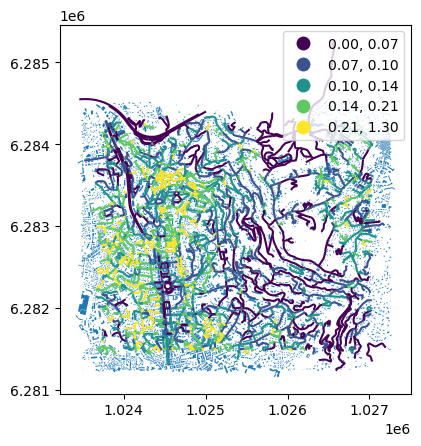

In [23]:
ax = sc.streets.assign(built_freq=street_df["built_freq"]).plot("built_freq", legend=True, scheme="quantiles")
buildings.plot(ax=ax)

In [24]:
dtm = rioxarray.open_rasterio("/data/uscuni-streetscape/data_from_marek/dtm/dtm_raw/RGEALTI_FXX_1025_6285_MNT_LAMB93_IGN69.asc")

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

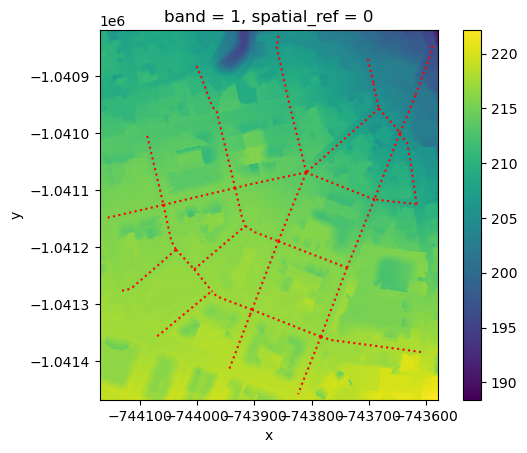

In [55]:
# f, ax = plt.subplots()
# dtm.plot(ax=ax)
# streets.plot(ax=ax, color="red", zorder=20, linestyle="dotted")

In [25]:
%%time
sc.compute_slope(dtm.drop_vars("band"))

CPU times: user 7.8 s, sys: 4 ms, total: 7.81 s
Wall time: 7.81 s


In [26]:
slope = sc.slope
slope.head()

,slope_degree,slope_percent,n_slopes,slope_valid
0,2.305050,0.040300,28,True
1,3.000322,0.052460,38,True
2,3.180801,0.055604,11,True
3,4.251692,0.074413,107,True
4,1.094379,0.019111,33,True


<Axes: >

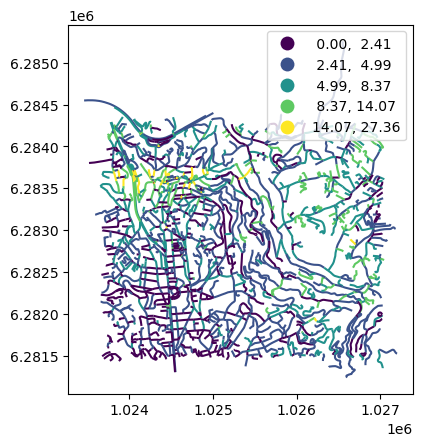

In [31]:
sc.streets.plot(slope.slope_degree.values, legend=True, scheme="naturalbreaks")
